In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Based on Fine-tune a language model tutorial: https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/language_modeling.ipynb

In [ ]:
!pip install transformers==4.28.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.5 MB/s eta 0:00:00


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd

df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/Common/social_media_clean.zip', compression='zip')

In [ ]:
df.isna().sum()

year              0
clean_text    92301
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.head()

,year,clean_text
0,2020,Как вы представляете себе идеальные отношения?...
1,2020,Наконец-то могу поделиться с вами этой новость...
2,2020,Моя Новая песня уже доступна на всех площадках...
3,2020,"«Будь, пожалуйста, послабее» ⠀ Это было моей ..."
4,2020,"Реакция Моцарта, когда самолёт взлетает- бесце..."


In [ ]:
from transformers import AutoTokenizer

model_checkpoint ='ai-forever/ruBert-base'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True, 
                                          padding=True, truncation=True)

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["clean_text"])

In [ ]:
block_size = 128

def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
from datasets import Dataset, DatasetDict

def get_datasets(df, year):
    train_size = int(0.9 * df.shape[0])
    train = df.sample(n=train_size)
    validation = df.drop(train.index)

    news_datasets = DatasetDict({'train': Dataset.from_pandas(train[['clean_text']]), 
                            'validation': Dataset.from_pandas(validation[['clean_text']])})
    news_datasets['train'] = news_datasets['train'].remove_columns('__index_level_0__')
    news_datasets['validation'] = news_datasets['validation'].remove_columns('__index_level_0__')

    tokenized_datasets = news_datasets.map(tokenize_function, batched=True, 
                                           num_proc=4, remove_columns=["clean_text"])
    lm_datasets = tokenized_datasets.map(group_texts, batched=True, 
                                         batch_size=1000, num_proc=4)
    
    lm_datasets.save_to_disk(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/BERT/sm_dataset_sber_128_{year}')

In [ ]:
from tqdm import tqdm

for year in tqdm(range(2007, 2020), leave=False):
    get_datasets(df[df.year == year], year)

In [ ]:
from datasets import load_from_disk, concatenate_datasets
from tqdm import tqdm

# We fine-tune the model ony for the periods we will create word prototypes
lm_datasets = None

for year in tqdm([2007, 2019]):
    if lm_datasets is None:
        lm_datasets = load_from_disk(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/BERT/sm_dataset_sber_128_{year}')
    else:
        temp_datasets = load_from_disk(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/BERT/sm_dataset_sber_128_{year}')
        lm_datasets['train'] = concatenate_datasets([lm_datasets['train'], temp_datasets['train']])
        lm_datasets['validation'] = concatenate_datasets([lm_datasets['validation'], temp_datasets['validation']])

100%|██████████| 2/2 [00:08<00:00,  4.08s/it]


In [ ]:
lm_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 156217
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 17634
    })
})

Fine-tune the model

In [ ]:
from transformers import AutoModelForMaskedLM
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling
from datasets import load_from_disk
import torch

model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

model_name = model_checkpoint.split("/")[-1]
training_args = TrainingArguments(
    f"{model_name}-finetuned-socia-media",
    evaluation_strategy = "epoch",
    num_train_epochs = 1.0,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=False,
)

# Do the masking
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
    data_collator=data_collator,
)

Some weights of the model checkpoint at ai-forever/ruBert-base were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,2.143100,1.953354


TrainOutput(global_step=9764, training_loss=2.2288093676287732, metrics={'train_runtime': 7475.4811, 'train_samples_per_second': 20.897, 'train_steps_per_second': 1.306, 'total_flos': 1.0290018209066496e+16, 'train_loss': 2.2288093676287732, 'epoch': 1.0})

In [ ]:
trainer.save_model('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/Social media/BERT/')
tokenizer.save_pretrained('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/Social media/BERT/tokenizer/')

('/content/gdrive/MyDrive/Colab Notebooks/HSE/Final/Models/BERT_1/tokenizer/tokenizer_config.json',
 '/content/gdrive/MyDrive/Colab Notebooks/HSE/Final/Models/BERT_1/tokenizer/special_tokens_map.json',
 '/content/gdrive/MyDrive/Colab Notebooks/HSE/Final/Models/BERT_1/tokenizer/vocab.txt',
 '/content/gdrive/MyDrive/Colab Notebooks/HSE/Final/Models/BERT_1/tokenizer/added_tokens.json',
 '/content/gdrive/MyDrive/Colab Notebooks/HSE/Final/Models/BERT_1/tokenizer/tokenizer.json')

Find all occurences of shared words to construct word prototypes and then find words with the most significant semantic shift

In [ ]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 71.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=cfff386479876fde3f3838c23f4e6237de994ebee62018a4e15e87ca8e0021e9
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/Social media/BERT/tokenizer/', use_fast=True)
model = AutoModelForMaskedLM.from_pretrained('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/Social media/BERT/', output_hidden_states=True)
model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
import torch 

def get_bert_embeddings(input, bert_model):
    with torch.no_grad():
        outputs = bert_model(torch.tensor(input['input_ids']).unsqueeze(dim=0).to(device),
                              token_type_ids=torch.tensor(input['token_type_ids']).unsqueeze(dim=0).to(device),
                              attention_mask=torch.tensor(input['attention_mask']).unsqueeze(dim=0).to(device))
        embeddings = outputs.hidden_states[-1][0, :, :].cpu().numpy()
    return embeddings

In [ ]:
import json

with open('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/Common/shared_words_social_media.json', 'r') as f:
    words = json.load(f)
words = [w[0] for w in words.items()]

In [ ]:
import pymorphy2
from datasets import load_from_disk
from tqdm import tqdm
import json
import numpy as np

# Let us find embeddings for words that are tokenized into one token
model.eval()
years = [2019, 2007]

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

morph = pymorphy2.MorphAnalyzer()

for year in tqdm(years):
    dataset = load_from_disk(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Socila media/BERT/sm_dataset_sber_128_{year}')
    words_dict = {'words': {}, 'count': {}}
    part = 0
    for i in tqdm(range(len(dataset['train']))):
        tokenized_text = tokenizer.convert_ids_to_tokens(dataset['train'][i]['input_ids'])
        lemmas = [morph.parse(w)[0].normal_form for w in tokenized_text]
        useful = False
        for word in words:
            if word in lemmas:
                useful = True
                break
        if useful:
            embeds = get_bert_embeddings(dataset['train'][i], model)
            for word in words:
                if word in lemmas:
                    for j, lem in enumerate(lemmas):
                        if lem == word:
                            embedding = embeds[j]
                            if word not in words_dict['words']:
                                words_dict['words'][word] = embedding
                                words_dict['count'][word] = 1
                            else:
                                words_dict['words'][word] = words_dict['words'][word] + embedding
                                words_dict['count'][word] += 1
        if i % 10000 == 0 and i != 0:
            for k, v in tqdm(words_dict['words'].items()):
                words_dict['words'][k] = words_dict['words'][k].tolist()
            with open(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/BERT/word_prototypes/bert_words_dict_sm_lem_{part}_{year}.json', 'w', encoding='utf-8') as f:
                json.dump(words_dict, f)
            part += 1
            words_dict = {'words': {}, 'count': {}}               
    
    for i in tqdm(range(len(dataset['validation']))):
        tokenized_text = tokenizer.convert_ids_to_tokens(dataset['validation'][i]['input_ids'])
        lemmas = [morph.parse(w)[0].normal_form for w in tokenized_text]
        useful = False
        for word in words:
            if word in lemmas:
                useful = True
                break
        if useful:
            embeds = get_bert_embeddings(dataset['validation'][i], model)
            for word in words:
                if word in lemmas:
                    for j, lem in enumerate(lemmas):
                        if lem == word:
                            embedding = embeds[j]
                            if word not in words_dict['words']:
                                words_dict['words'][word] = embedding
                                words_dict['count'][word] = 1
                            else:
                                words_dict['words'][word] = words_dict['words'][word] + embedding
                                words_dict['count'][word] += 1
    
    for k, v in tqdm(words_dict['words'].items()):
          words_dict['words'][k] = words_dict['words'][k].tolist()
    
    with open(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/BERT/word_prototypes/bert_words_dict_sm_lem_{part}_{year}.json', 'w', encoding='utf-8') as f:
        json.dump(words_dict, f)

Выходные данные были обрезаны до нескольких последних строк (5000).
 75%|███████▌  | 19998/26628 [17:01<05:17, 20.89it/s]

  0%|          | 0/5171 [00:00<?, ?it/s]

100%|██████████| 5171/5171 [00:00<00:00, 25893.76it/s]

100%|██████████| 26628/26628 [22:58<00:00, 19.31it/s]

 27%|██▋       | 865/3195 [00:41<01:48, 21.53it/s]

In [ ]:
import json
import numpy as np
from tqdm import tqdm

words_dict_2019 = {}

for i in tqdm(range(13)):
    if not words_dict_2019:
        with open(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/BERT/word_prototypes/bert_words_dict_sm_lem_{i}_2019.json', 'r', encoding='utf-8') as f:
            words_dict_2019 = json.load(f)
    else:
        with open(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/BERT/word_prototypes/bert_words_dict_sm_lem_{i}_2019.json', 'r', encoding='utf-8') as f:
            words_dict_temp = json.load(f)
        for w in words_dict_temp['words'].keys():
            if w in words_dict_2019['words']:
                words_dict_2019['words'][w] = np.array(words_dict_2019['words'][w]) + np.array(words_dict_temp['words'][w])
                words_dict_2019['count'][w] = int(words_dict_2019['count'][w]) + int(words_dict_temp['count'][w]) 
            else:
                words_dict_2019['words'][w] = np.array(words_dict_temp['words'][w])
                words_dict_2019['count'][w] = int(words_dict_temp['count'][w])

100%|██████████| 13/13 [01:00<00:00,  4.62s/it]


In [ ]:
words_dict_2007 = None
for i in range(3):
    if words_dict_2007 is None:
        with open(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/BERT/word_prototypes/bert_words_dict_sm_lem_{i}_2007.json', 'r', encoding='utf-8') as f:
            words_dict_2007 = json.load(f)
    else:
        with open(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/BERT/word_prototypes/bert_words_dict_sm_lem_{i}_2007.json', 'r', encoding='utf-8') as f:
            words_dict_temp = json.load(f)
        for w in words_dict_temp['words'].keys():
            if w in words_dict_2007['words']:
                words_dict_2007['words'][w] = np.array(words_dict_2007['words'][w]) + np.array(words_dict_temp['words'][w])
                words_dict_2007['count'][w] = int(words_dict_2007['count'][w]) + int(words_dict_temp['count'][w]) 
            else:
                words_dict_2007['words'][w] = np.array(words_dict_temp['words'][w])
                words_dict_2007['count'][w] = int(words_dict_temp['count'][w])

In [ ]:
# Let us find embeddings for words that are tokenized into several tokens
complex_words = []
for word in words:
    if len(tokenizer.encode(word)[1:-1]) > 1:
        complex_words.append(word)

In [ ]:
import pandas as pd
from datasets import load_from_disk
from ast import literal_eval
from tqdm import tqdm
import json
import numpy as np

model.eval()
years = [2019б 2017]

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

for year in tqdm(years):
    df = pd.read_csv(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/Common/data_v1_{year}.csv', compression='zip',
                          converters={'tokenized_text': literal_eval, 'lemmas': literal_eval})
  
    words_dict = {'words': {}, 'count': {}}
    part = 0

    for i in tqdm(range(df.shape[0])):
        useful = False
        for word in complex_words:
            if word in df.lemmas.iloc[i]:
                useful = True
                break

        if useful:
            tokens = tokenizer(' '.join(df.lemmas.iloc[i]), truncation=True, padding=True, max_length=512)
            embeds = get_bert_embeddings(tokens, model)

            for word in complex_words:
                t = tokenizer.encode(word)[1:-1]
                for j, tok in enumerate(tokens['input_ids']):
                    if tok == t[0]:
                        embed = embeds[j]
                        for k in range(1, len(t)):
                            if t[k] == tokens['input_ids'][j+k]:
                                embed += embeds[j+k]
                            else:
                                embed = None
                                break 

                        if embed is not None:
                            if word not in words_dict['words']:
                                words_dict['words'][word] = embed
                                words_dict['count'][word] = 1
                            else:
                                words_dict['words'][word] = words_dict['words'][word] + embed
                                words_dict['count'][word] += 1

        if i % 20000 == 0 and i != 0:
            for k, v in tqdm(words_dict['words'].items()):
                words_dict['words'][k] = words_dict['words'][k].tolist()
            with open(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/BERT/wort_prototypes/bert_words_dict_sm_complex_lem_{part}_{year}.json', 'w', encoding='utf-8') as f:
                json.dump(words_dict, f)
            part += 1
            words_dict = {'words': {}, 'count': {}}  

    for k, v in tqdm(words_dict['words'].items()):
          words_dict['words'][k] = words_dict['words'][k].tolist()
    
    with open(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/BERT/wort_prototypes/bert_words_dict_sm_complex_lem_{part}_{year}.json', 'w', encoding='utf-8') as f:
        json.dump(words_dict, f)

Streaming output truncated to the last 5000 lines.
100%|██████████| 113336/113336 [3:06:07<00:00, 10.15it/s]

100%|██████████| 1/1 [3:06:19<00:00, 11179.04s/it]


In [ ]:
for i in range(12):
    with open(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/BERT/wort_prototypes/bert_words_dict_sm_complex_lem_{i}_2019.json', 'r', encoding='utf-8') as f:
        words_dict_temp = json.load(f)
    for w in words_dict_temp['words'].keys():
        if w in words_dict_2019['words']:
            words_dict_2019['words'][w] = np.array(words_dict_2019['words'][w]) + np.array(words_dict_temp['words'][w])
            words_dict_2019['count'][w] = int(words_dict_2019['count'][w]) + int(words_dict_temp['count'][w]) 
        else:
            words_dict_2019['words'][w] = np.array(words_dict_temp['words'][w])
            words_dict_2019['count'][w] = int(words_dict_temp['count'][w])

for i in range(7):
    with open(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/BERT/wort_prototypes/bert_words_dict_sm_complex_lem_{i}_2007.json', 'r', encoding='utf-8') as f:
        words_dict_temp = json.load(f)
    for w in words_dict_temp['words'].keys():
        if w in words_dict_2007['words']:
            words_dict_2007['words'][w] = np.array(words_dict_2007['words'][w]) + np.array(words_dict_temp['words'][w])
            words_dict_2007['count'][w] = int(words_dict_2007['count'][w]) + int(words_dict_temp['count'][w]) 
        else:
            words_dict_2007['words'][w] = np.array(words_dict_temp['words'][w])
            words_dict_2007['count'][w] = int(words_dict_temp['count'][w])

In [ ]:
# Let us compute average embeddings for each word (word prototypes)

embeds_2019 = {}
for w in words_dict_2019['words'].keys():
    embeds_2019[w] = np.array(words_dict_2019['words'][w]) / int(words_dict_2019['count'][w])

embeds_2007 = {}
for w in words_dict_2007['words'].keys():
    embeds_2007[w] = np.array(words_dict_2007['words'][w]) / int(words_dict_2007['count'][w])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

cosine_similarities ={}

words = set(words_dict_2019['words'].keys()).intersection(set(words_dict_2007['words'].keys()))

for word in words:
    cosine_similarities[word] = cosine_similarity([embeds_2007[word]], 
                                                  [embeds_2019[word]])[0][0]
                                                  
top_20 = sorted(cosine_similarities.items(), key=lambda item: item[1])[:20]
top_20

[('зенит', 0.18852166043235744),
 ('приведа', 0.2914131505272189),
 ('убогий', 0.3063994012817744),
 ('защититься', 0.3324248521561506),
 ('малина', 0.3622782669578053),
 ('серж', 0.37853222232827455),
 ('замешать', 0.4054381995246914),
 ('охарактеризовать', 0.4562722892894526),
 ('чь', 0.48803441809712234),
 ('кончать', 0.49578752227649575),
 ('взаимопонимание', 0.5048862599196822),
 ('делить', 0.5057286610470086),
 ('полярный', 0.5059866882000884),
 ('вырубить', 0.5275496762651828),
 ('зевать', 0.532182291032729),
 ('тесный', 0.5375188774083921),
 ('пь', 0.5394026913505867),
 ('взрывать', 0.5565751973336444),
 ('спасти', 0.5570035784946308),
 ('противный', 0.5585680242818741)]

In [ ]:
for word in top_20:
    cosine_similarities_2007 = {}
    cosine_similarities_2019 = {}
    for w in words:
        cosine_similarities_2007[w] = cosine_similarity([embeds_2007[word[0]]], 
                                                        [embeds_2007[w]])[0][0]
        cosine_similarities_2019[w] = cosine_similarity([embeds_2019[word[0]]], 
                                                        [embeds_2019[w]])[0][0]
    print(word[0])
    print(sorted(cosine_similarities_2007.items(), key=lambda item: item[1], reverse=True)[:10])
    print(sorted(cosine_similarities_2019.items(), key=lambda item: item[1], reverse=True)[:10])

зенит
[('зенит', 1.0000000000000009), ('приведа', 0.5509671824713801), ('сера', 0.5362702350970892), ('па', 0.5320686119364958), ('н', 0.5320110761589554), ('оля', 0.5223631635309581), ('сеня', 0.5220103381395133), ('тво', 0.5133166884828284), ('ме', 0.5011111758364244), ('бер', 0.4977763947362097)]
[('зенит', 1.0000000000000009), ('полдень', 0.5914154288994302), ('нева', 0.5700633848839838), ('закат', 0.5691785621106816), ('болото', 0.5542295299996947), ('колонка', 0.5503816612920938), ('нить', 0.5495654043815109), ('столбик', 0.5480437729547537), ('лик', 0.5444740690643731), ('пижама', 0.5415649288694289)]
приведа
[('приведа', 0.9999999999999996), ('белов', 0.8315021881103196), ('баста', 0.8017832677989767), ('мах', 0.7963213971616977), ('паша', 0.7732484420428993), ('зевать', 0.7662435162758137), ('взаимопонимание', 0.7662275460017165), ('костя', 0.7649721075923257), ('защититься', 0.7576066941780685), ('святой', 0.748766999192276)]
[('приведа', 1.0000000000000004), ('привести', 0.8

In [ ]:
vectors_2007 = embeds_2007
vectors_2019 = embeds_2019

100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


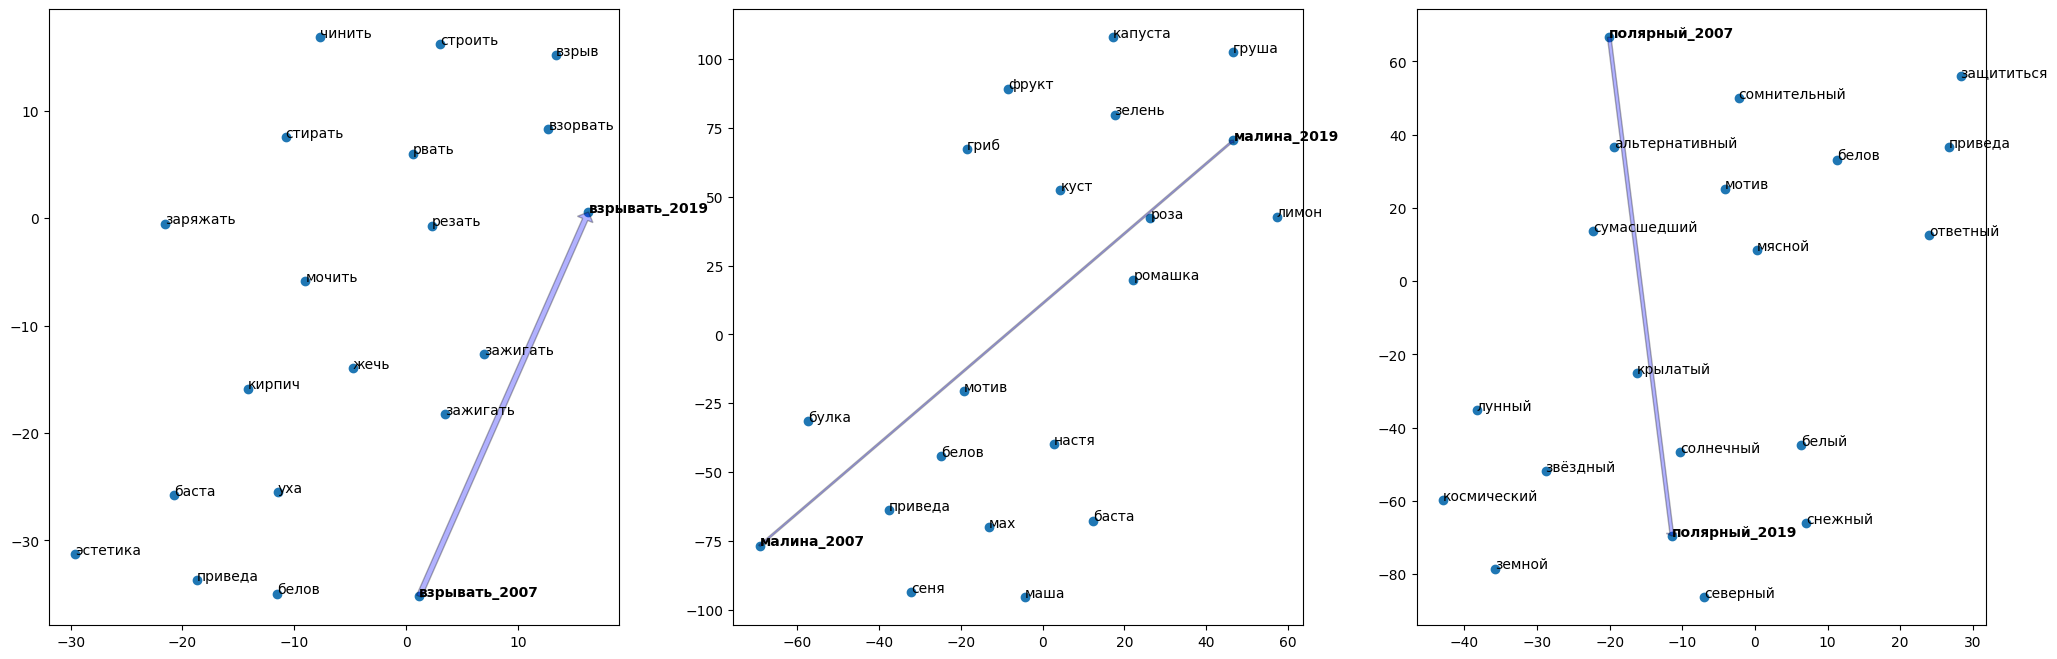

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

words = ['взрывать', 'малина', 'полярный']

list_2007 = list(vectors_2007.items())
words_2007 = list(map(lambda x: x[0], list_2007))
embeddings_2007 = list(map(lambda x: x[1], list_2007))

list_2019 = list(vectors_2019.items())
words_2019 = list(map(lambda x: x[0], list_2019))
embeddings_2019 = list(map(lambda x: x[1], list_2019))

points = []
all_keys = []

for word in tqdm(words):
    K_2007 = cosine_similarity([vectors_2007[word]],embeddings_2007)
    K_2019 = cosine_similarity([vectors_2019[word]],embeddings_2019)

    wids_2007 = np.argsort(-abs(K_2007[0]))
    wids_2007 = wids_2007[0:10]
    w_closest_2007 = [words_2007[w] for w in wids_2007[1:]]

    wids_2019 = np.argsort(-abs(K_2019[0]))
    wids_2019 = wids_2019[0:10]
    w_closest_2019 = [words_2019[w] for w in wids_2019[1:]]

    all_words = w_closest_2007
    all_words.extend(w_closest_2019)
    all_words.extend([f'{word}_2007', f'{word}_2019'])
    
    embeds_2007 = [embeddings_2007[w] for w in wids_2007[1:]]
    embeds_2019 = [embeddings_2019[w] for w in wids_2019[1:]]

    all_embeds = embeds_2007
    all_embeds.extend(embeds_2019)
    all_embeds.extend([vectors_2007[word], vectors_2019[word]])

    # Fit t-SNE
    mat = np.array(all_embeds)
    model = TSNE(n_components=2, random_state=0, init='pca', perplexity=10)
    fitted = model.fit_transform(mat)
    points.append(fitted)
    all_keys.append(all_words)

fig, ax = plt.subplots(1, 3)

fig.set_figheight(8)
fig.set_figwidth(25)

for j in range(3):
    fitted = points[j]
    x = fitted[:, 0]
    y = fitted[:, 1]
    keys = all_keys[j]

    ax[j].scatter(x, y)

    for i, txt in enumerate(keys):
        if len(keys) - i <= 2:
            ax[j].annotate(txt, (x[i], y[i]), weight='bold')
        else:
            ax[j].annotate(txt, (x[i], y[i]))
    
    ax[j].arrow(fitted[-2, 0], fitted[-2, 1], (fitted[-1, 0] - fitted[-2, 0]), 
              (fitted[-1, 1] - fitted[-2, 1]), facecolor='blue', alpha=0.3, width=0.5,
              head_length=0.75, length_includes_head=True)
fig.savefig(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Vectors/sm_bert.png')